In [13]:
import cv2
import pandas as pd
import numpy as np
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import matplotlib.pyplot as plt

In [14]:
data_train_path = './train/'
face_cascade = cv2.CascadeClassifier('xml.xml')

videocapture=cv2.VideoCapture(data_train_path + '2.MOV')

In [15]:
def detect_face(frame):
    faces = face_cascade.detectMultiScale(frame, 1.1, 4)
    return faces[0]

def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

def safe_div(x,y): # so we don't crash so often
    if y==0: return 0
    return x/y

def nothing(x): # for trackbar
    pass

def rescale_frame(frame, percent=25):  # make the video windows a bit smaller
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

if not videocapture.isOpened():
    print("can't open camera")
    exit()

In [16]:
windowName="Webcam Live video feed"

In [17]:
closing_s = []

xIM1, yIM1, wIM1, hIM1 = 0, 0, 0, 0
for i in range(4):
    ret, frame=videocapture.read()
    xIM, yIM, wIM, hIM = detect_face(frame)
    if wIM+hIM > wIM1+hIM1:
        xIM1, yIM1, wIM1, hIM1 = xIM, yIM, wIM, hIM
print(xIM1, yIM1, wIM1, hIM1)

783 206 269 269


In [19]:
showLive=True
while(showLive):
    
    ret, frame=videocapture.read()
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #cv.rectangle(frame, (x-w, 0), (x+2*w, 480), (255, 0, 0), 2)
    try:
        frame = frame[yIM1+hIM1:, xIM1-2*wIM1:xIM1+3*wIM1]
    except:
        break
    

    frame_resize = rescale_frame(frame)
    if not ret:
        print("cannot capture the frame")
        exit()
   
    #thresh= cv2.getTrackbarPos("threshold", windowName) 
    thresh = 75
    ret,thresh1 = cv2.threshold(frame_resize,thresh,255,cv2.THRESH_BINARY) 
    thresh1 = (255-thresh1)
    #cv2.imwrite(name, imagem)
    
    #kern=cv2.getTrackbarPos("kernel", windowName) 
    kern = 1
    kernel = np.ones((kern,kern),np.uint8) # square image kernel used for erosion
    
    #itera=cv2.getTrackbarPos("iterations", windowName) 
    itera = 1
    dilation = cv2.dilate(thresh1, kernel, iterations=itera)
    erosion = cv2.erode(dilation,kernel,iterations = itera) # refines all edges in the binary image

    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)  
    closing = cv2.cvtColor(closing,cv2.COLOR_BGR2GRAY)
    
    contours,hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # find contours with simple approximation cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE

    closing = cv2.cvtColor(closing,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(closing, contours, -1, (128,255,0), 1)
    
    # focus on only the largest outline by area
    areas = [] #list to hold all areas

    for contour in contours:
      ar = cv2.contourArea(contour)
      areas.append(ar)

    if len(areas) > 0:
        max_area = max(areas)
        max_area_index = areas.index(max_area)  # index of the list element with largest area

        cnt = contours[max_area_index - 1] # largest area contour is usually the viewing window itself, why?

        cv2.drawContours(closing, [cnt], 0, (0,0,255), 1)
        
        def midpoint(ptA, ptB): 
            return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

        # compute the rotated bounding box of the contour
        orig = frame_resize.copy()
        box = cv2.minAreaRect(cnt)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)
    
        # loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
        
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        
        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
        
        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 1)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 1)
        cv2.drawContours(orig, [cnt], 0, (0,0,255), 1)
        
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # compute the size of the object
        pixelsPerMetric = 1 # more to do here to get actual measurements that have meaning in the real world
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric
    
        # draw the object sizes on the image
        #cv2.putText(orig, "{:.1f}mm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
        #cv2.putText(orig, "{:.1f}mm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

        # compute the center of the contour
        M = cv2.moments(cnt)
        cX = int(safe_div(M["m10"],M["m00"]))
        cY = int(safe_div(M["m01"],M["m00"]))
    
        # draw the contour and center of the shape on the image
        cv2.circle(orig, (cX, cY), 5, (255, 255, 255), -1)
        cv2.putText(orig, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
        #cv2.imshow(windowName, orig)
        for i in range(len(closing)):
            for j in range(len(closing[i])):
                if closing[i][j].sum() < 255*3:
                    closing[i][j] = [0, 0, 0]

        closing_s += [closing]
        cv2.imshow('', closing)
        if cv2.waitKey(30)>=0:            #//НАЧАЛЬНАЯ
            showLive=False
cv2.destroyAllWindows()

In [20]:
videocapture.release()
cv2.destroyAllWindows()

closing_delts = []
print(type(closing_s[0]))

delts = np.zeros(len(closing_s)-1, dtype=int)

<class 'numpy.ndarray'>


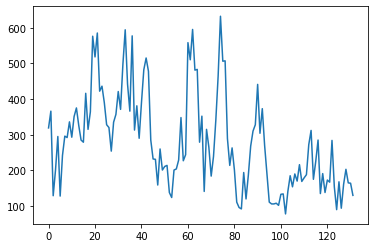

In [25]:

for i in range(1, len(closing_s)):
    cl_dl = closing_s[i] - closing_s[i-1]
    closing_delts += [cl_dl]
    cv2.imshow('cl_dl', cl_dl)
    cv2.waitKey(60)        #delts

    delts[i-1] = cl_dl.sum()/(255*3)

cv2.destroyAllWindows()
plt.plot(delts)
plt.show()

In [9]:
data = np.array([[]])